# Практическое задание 1. Обучение полносвязной нейронной сети.

In [1]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных (0 баллов)

Если вам требуется работать с каким-нибудь набором данных (dataset), то, прежде всего, проверьте, нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

100%|██████████| 26421880/26421880 [00:04<00:00, 5652251.33it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 343446.32it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3434335.41it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16419982.50it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [3]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [4]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [5]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):
        if train:
            images, labels = load_mnist(os.path.join(path,"raw"))
        else:
            images, labels = load_mnist(os.path.join(path,"raw"), kind="t10k")

        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        self.images = images
        self.labels = labels
        self.image_transform = image_transform
        self.label_transform = label_transform

    def __len__(self,):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        length = len(self.images)
        return length

    def __getitem__(self, idx):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        img = self.images[idx]
        if self.image_transform:
            img = self.image_transform(img)
        label = np.asarray(self.labels[idx])

        if self.label_transform:
            label = self.label_transform(label)

        return img.reshape(28, 28), label


In [6]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

Визуализируйте случайные элементы набора данных.

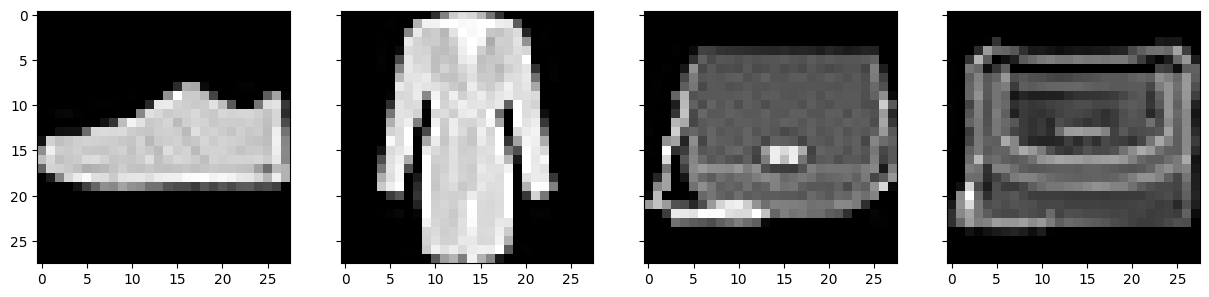

In [13]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
fig, axes = plt.subplots(1, 4, figsize = (15, 5), sharey=True)
idxs = np.random.randint(len(train_dataset), size=4)

axes[0].imshow(train_dataset[idxs[0]][0], cmap='grey')
axes[1].imshow(train_dataset[idxs[1]][0], cmap='grey')
axes[2].imshow(train_dataset[idxs[2]][0], cmap='grey')
axes[3].imshow(train_dataset[idxs[3]][0], cmap='grey')

plt.show()

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [153]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)

In [154]:
transform = ToTensor()

test_dataset = FashionMnist("data/FashionMNIST",
                            train=False,
                            image_transform=transform,
                            label_transform=transform
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=transform,
                             label_transform=transform
                             )

In [155]:
print(f"The type of the data is {type(test_dataset[0][0])}")

The type of the data is <class 'torch.Tensor'>


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [185]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [186]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([60, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [187]:
def collate(batch):
    ###########################################################
    ############# YOUR CODE HERE ##############################
    ###########################################################
    imgs = torch.stack([sample[0] for sample in batch], dim=0).to(torch.float32)
    labels = torch.stack([sample[1] for sample in batch], dim=0)
    return imgs, labels

Убедитесть, что все работает корректно.

In [456]:
test_dataloader = DataLoader(test_dataset, batch_size=128, num_workers=2,
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=128, num_workers=2,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

In [457]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([128, 28, 28])


## 2. Реализация модулей нейронной сети (15 баллов)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [216]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [217]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU (1 балл)
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [218]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        ctx.save_for_backward(inp)
        output = inp.clone().detach()
        output[output < 0] = 0
        return output

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        inp, = ctx.saved_tensors
        return grad_output * (inp > 0) 


In [219]:
class ReLU(nn.Module):
    def __init__(self):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        super().__init__()
        self.relu = ReLUFunction.apply


    def forward(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.relu(inp)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [220]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
x = torch.randn(3, 5, requires_grad=True, dtype=torch.float64)
relu = ReLUFunction.apply

assert gradcheck(relu, x)

In [221]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################

assert torch.norm(nn.ReLU()(x.float()) - relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected) (3 балла)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [222]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        ctx.save_for_backward(inp, weight, bias)
        output = inp.mm(weight.T) + bias.unsqueeze(0)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        inp, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.T.mm(inp)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)

        return grad_input, grad_weight, grad_bias

In [379]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()
        # initialize weights with small random numbers from normal distribution
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        super().__init__()
        self.linear = LinearFunction.apply
        std = 1 / input_units**0.5
        self.weight = nn.Parameter(2 * std * torch.rand(output_units, input_units, dtype=torch.float32) - std)
        self.bias = nn.Parameter(2 * std * torch.rand(output_units, dtype=torch.float32) - std)

    def forward(self,inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################

        return self.linear(inp, self.weight, self.bias)

Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [380]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
input_units = 28
output_units = 16

x = torch.randn(4, input_units, requires_grad=True, dtype=torch.float64)
weight = torch.randn(output_units, input_units, dtype=torch.float64)
bias = torch.randn(output_units, dtype=torch.float64)

linear = LinearFunction.apply

assert gradcheck(linear, (x, weight, bias))

Сравнение с `PyTorch`.

In [381]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
torch_linear = nn.Linear(input_units, output_units)
our_linear = Linear(input_units, output_units)

weight = torch.randn(output_units, input_units, dtype=torch.float32)
bias = torch.randn(output_units, dtype=torch.float32)

state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)

x = torch.randn(4, input_units, requires_grad=True, dtype=torch.float32)
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
assert torch.norm(torch_linear(x) - our_linear(x)) < 1e-5

### 2.3 LogSoftmax (Log + Softmax) (4 балла)

Для решения задачи многоклассовой классификации обычно используют `softmax` в качестве нелинейности на последнем слое, чтобы получить "оценку" вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой `LogSoftmax` (без параметров). Метод `forward` должен вычислять логарифм от `softmax`, а метод `backward` - пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

Для полного балла нужна имплементация с `Log-Sum-Exp trick`.

In [382]:
class LogSoftmaxFunction(Function):
    @staticmethod
    def forward(ctx, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        ctx.save_for_backward(inp.clone().detach())
        output = inp.clone().detach()
        c = torch.amax(output, -1)
        output -= c.unsqueeze(-1)
        output = output - torch.log(torch.exp(output).sum(-1)).unsqueeze(-1)
        return output


    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        inp, = ctx.saved_tensors
        tmp = torch.exp(inp - torch.amax(inp, -1).unsqueeze(-1))
        sftmx = tmp / tmp.sum(1).unsqueeze(-1)
        weights = grad_output.sum(1).unsqueeze(-1)
        return grad_output - weights * sftmx

In [383]:
class LogSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        super().__init__()
        self.logsoftmax = LogSoftmaxFunction.apply


    def forward(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################

        return self.logsoftmax(inp)

Проверка градиентов.

In [384]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################

x = torch.randn(15, 32, requires_grad=True, dtype=torch.float64)
logsoftmax = LogSoftmaxFunction.apply

assert gradcheck(logsoftmax, x)

In [385]:
assert torch.norm(nn.LogSoftmax(dim=1)(x) - logsoftmax(x)) < 1e-5

### 2.4 Dropout (2 балла)
Реализуйте слой Dropout.

In [444]:
class DropoutFunction(Function):
    @staticmethod
    def forward(ctx, inp, p):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        mask = torch.bernoulli(torch.ones_like(inp) - p)
        output = mask * inp
        ctx.save_for_backward(mask)
        return output
        

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        mask, = ctx.saved_tensors
        return grad_output * mask, None

In [445]:
class Dropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        super().__init__()
        self.dropout = DropoutFunction.apply
        self.p = p

    def forward(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        if self.training:
            return self.dropout(inp, self.p)
        else:
            return inp * (1 - self.p)

### 2.5 CrossEntropy (5 баллов)

При решении задачи многоклассовой классификации мы будет использовать в качестве функции потерь **кроссэнтропию, совместимую с `LogSoftmax` активацией**. 

Реализуйте эту функцию потерь. В разделе 2.3 приведены полезные формулы.

In [446]:
class CrossEntropyFunction(Function):
    @staticmethod
    def forward(ctx, activations, target):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        target_long = target.to(torch.long)
        ctx.save_for_backward(activations, target_long)
        return -activations[range(activations.shape[0]), target_long].mean()

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        activations, target = ctx.saved_tensors
        grad_input = torch.zeros_like(activations)
        grad_input[range(grad_input.shape[0]), target] = -1 / activations.shape[0]
        return grad_output * grad_input, None

class CrossEntropy(nn.Module):
    def __init__(self):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        self.cross_entropy = CrossEntropyFunction.apply

    def forward(self, activations, target):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.cross_entropy(activations, target)

Проверка градиентов.

In [447]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
sample_num = 15
x = torch.randn(sample_num, 10, dtype=torch.float64)
x = LogSoftmaxFunction.apply(x)
x.requires_grad = True
target = torch.randint(10, size=(sample_num,))
layer = CrossEntropy()

assert gradcheck(layer, (x, target))

## 3. Сборка и обучение нейронной сети (5 баллов)

Реализуйте из ваших блоков персептрон и обучите его, залоггировав итоговый лосс и метрику на валидационной выборке. **(1 балл)**

Подсказка: вытягиваем картинку в вектор с помощью [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In [448]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        self.input_layer = Linear(input_size, hidden_layers_size)
        self.hidden_layers = nn.Sequential(*[Linear(hidden_layers_size, hidden_layers_size) for _ in range(num_layers-2)])
        self.output_layer = Linear(hidden_layers_size, num_classes)

        self.activation = ReLU()
        self.dropout = Dropout(p=0.1)
        self.logsoftmax = LogSoftmax()
        self.flatten = nn.Flatten()

    def forward(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        out = self.activation(self.input_layer(self.flatten(inp)))
        for hidden_layer in self.hidden_layers:
            out = self.activation(hidden_layer(self.dropout(out)))
        out = self.output_layer(self.dropout(out))
        return self.logsoftmax(out)


    def predict(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        out = self.activation(self.input_layer(self.flatten(inp)))
        for hidden_layer in self.hidden_layers:
            out = self.activation(hidden_layer(self.dropout(out)))
        out = self.output_layer(self.dropout(out))
        return out.argmax(1)

Ниже приведены функции, реализующие обучение нейронной сети. В данном задании их предлагается просто переиспользовать.

In [449]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [450]:
# accuracy metric for our classififcation
def accuracy(model_labels, labels):
    return torch.mean((model_labels == labels).float())

In [458]:
def perform_epoch(model, loader, criterion,
                optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            model_labels = model(batch_data)
            model_prediction = model.predict(batch_data)
            new_loss = criterion(model_labels, batch_labels)
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              optimizer.step()

            one_batch_loss = float(criterion(model_labels, batch_labels))
            one_batch_acc = accuracy(model_prediction, batch_labels)

            total_loss += one_batch_loss
            total_acc += one_batch_acc
            total_n += 1
    return (total_loss / total_n, total_acc / total_n)

Теперь обучим нашу нейронную сеть. В данном разделе будем использовать оптимизатор `Adam` с параметрами по умолчанию.

In [465]:
model     = Network() #your network
optimizer = Adam(model.parameters())#your optimizer
criterion = CrossEntropy()#your loss

In [466]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 0.9208721554736847, accuracy 0.6611252427101135
Current learning rate: 0.001
Epoch - 1 : loss 0.6134663290941893, accuracy 0.782488226890564
Current learning rate: 0.001
Epoch - 2 : loss 0.5647806806732089, accuracy 0.80330491065979
Current learning rate: 0.001
Epoch - 3 : loss 0.5423170118443748, accuracy 0.8114394545555115
Current learning rate: 0.001
Epoch - 4 : loss 0.5198750490827093, accuracy 0.8151152729988098
Current learning rate: 0.001
Epoch - 5 : loss 0.50524333055848, accuracy 0.8234330415725708
Current learning rate: 0.001
Epoch - 6 : loss 0.49597279451040827, accuracy 0.8253486752510071
Current learning rate: 0.001
Epoch - 7 : loss 0.49064518597080253, accuracy 0.8278140425682068
Current learning rate: 0.001
Epoch - 8 : loss 0.48188145855850756, accuracy 0.8321673274040222
Current learning rate: 0.001
Epoch - 9 : loss 0.4789620137799269, accuracy 0.8333666920661926
Current learning rate: 0.001


In [467]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 0.4789620137799269, accuracy 0.8333666920661926
Current learning rate: 0.001


Дальше **(4 балла)**:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

Training Loop для выполнения этой части задания можно и нужно улучшать, в том числе, добавляя более продвинутое логгирование эксперимента.

In [472]:
from tqdm import tqdm

num_exp = 8
num_epoch = 10
criterion = CrossEntropy()
layers_range = list(range(3, 12))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
experiment_results = [[[], [], [], []] for _ in layers_range]

for i, num_layers in enumerate(tqdm(layers_range)):
    for _ in range(num_exp):
        model = Network(num_layers=num_layers)
        optimizer = Adam(model.parameters())

        model.to(device)
        for epoch in range(num_epoch):
            loss_train, acc_train = perform_epoch(model, train_dataloader, criterion, optimizer=optimizer, device=device)

        experiment_results[i][0].append(loss_train)
        experiment_results[i][1].append(acc_train.item())

        loss_val, acc_val = perform_epoch(model, test_dataloader, criterion, optimizer=None, device=device)
        experiment_results[i][2].append(loss_val)
        experiment_results[i][3].append(acc_val.item())

100%|██████████| 9/9 [49:26<00:00, 329.56s/it]


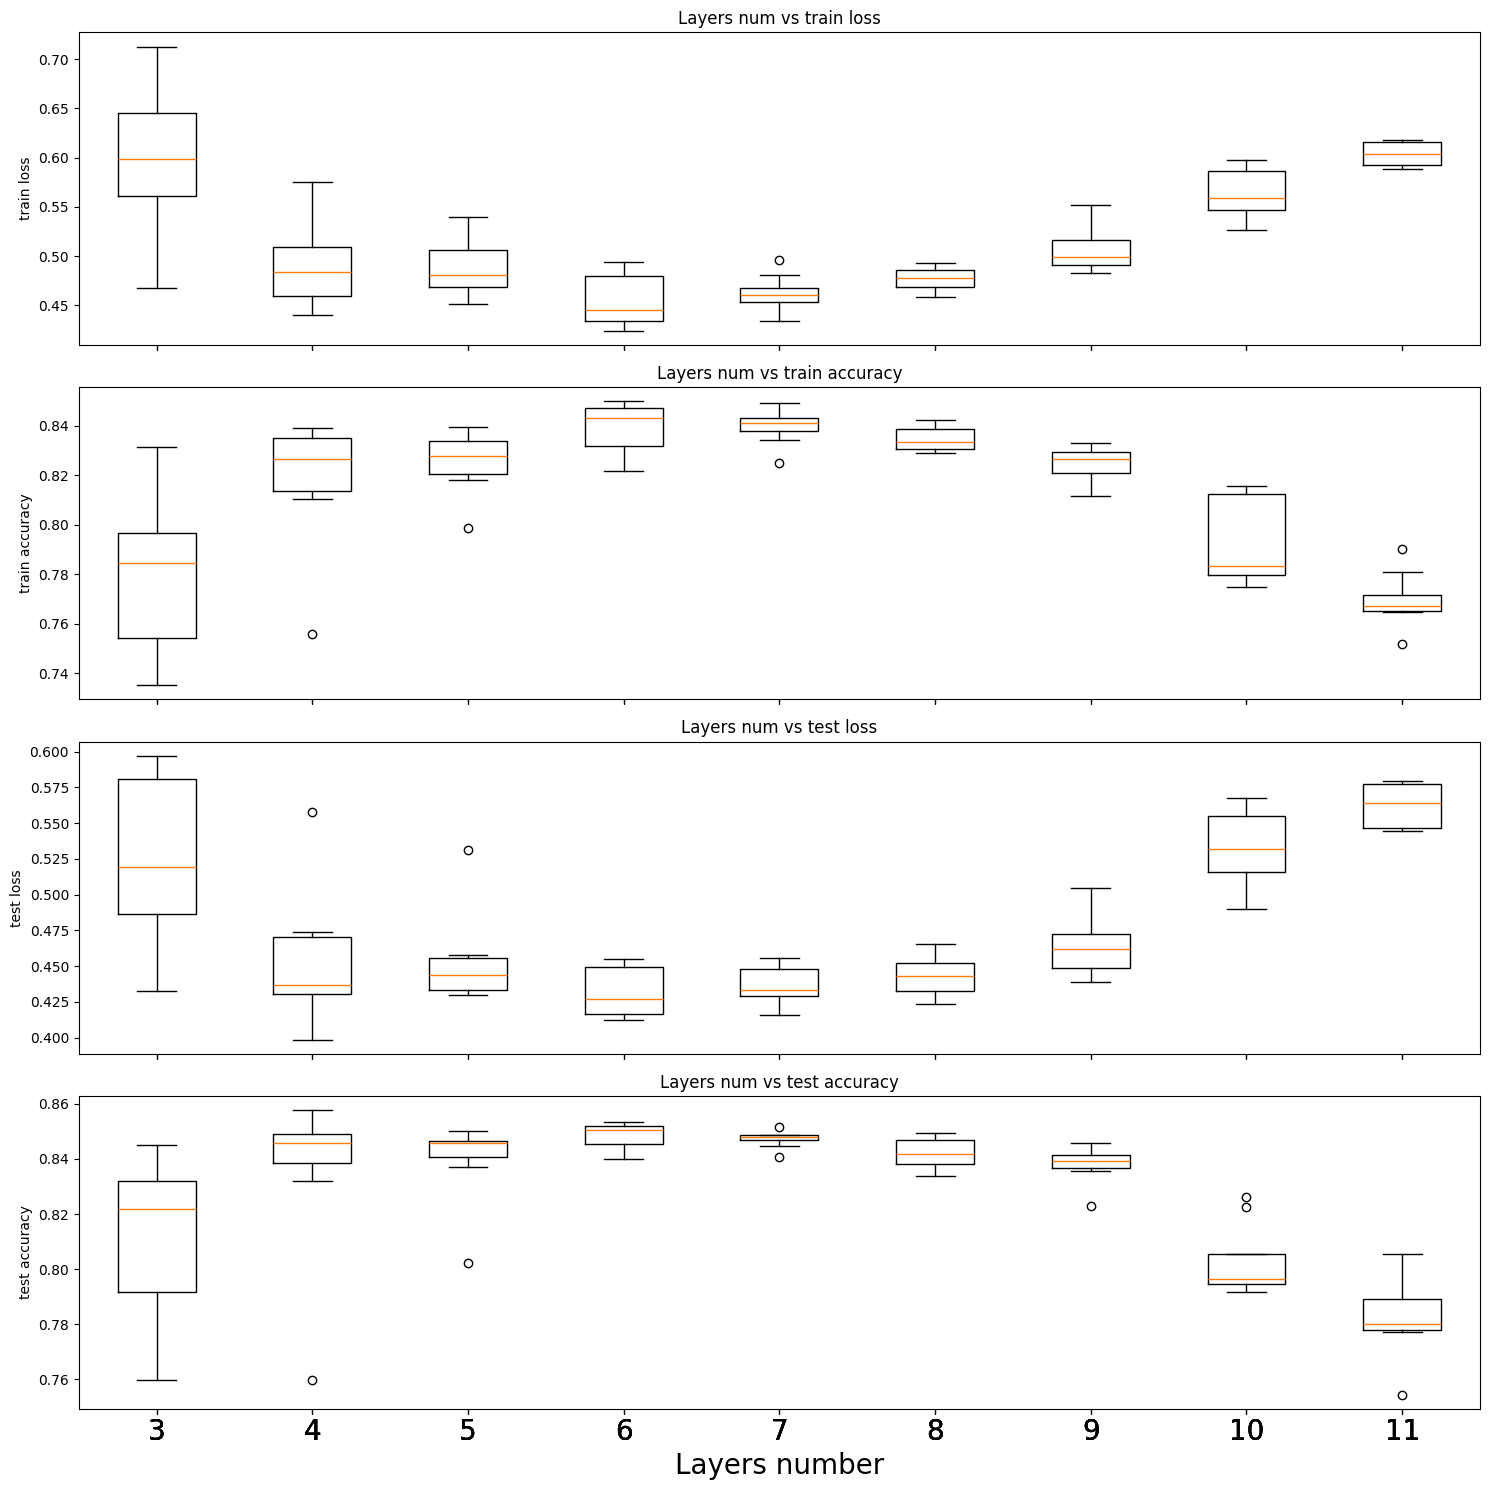

In [534]:
tmp = np.array(experiment_results)

fig, axes = plt.subplots(4, 1, figsize = (15, 15), sharex=True)
ylabels = ['train loss', 'train accuracy', 'test loss', 'test accuracy']

for i, v in enumerate(axes):
    v.set_title('Layers num vs ' + ylabels[i])
    v.set_ylabel(ylabels[i])
    v.boxplot(tmp[:, i, :].T, tick_labels=layers_range)


plt.xlabel('Layers number', fontsize=20)
plt.xticks(size=20)
plt.tight_layout()
plt.show()

#### На картинках видно, что есть некоторая зависимость, похожая на унимодальную. Если слоев было 6-7, то результаты были стабильные и точность была похожая между всеми прогонами экспериментов. Если слоев становилось больше или меньше, то и результат становился более нестабилен, а также средняя точность экспериментов падала.

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (3 + 3 балла).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam.

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание.

In [577]:
class SotaOptimizer(Optimizer): # RMSprop
    def __init__(self, params, lr=1e-3, alpha=0.99, 
                 eps=1e-08, weight_decay=0, momentum=0, centered=False):
        defaults = dict(lr=lr, alpha=alpha, eps=eps, wd=weight_decay, mom=momentum)
        self.centered = centered
        super(SotaOptimizer, self).__init__(params, defaults)
        self.state = dict() 
        for group in self.param_groups: 
            for p in group['params']: 
                self.state[p] = dict(v=torch.zeros_like(p.data, device=p.data.device),
                                     b=torch.zeros_like(p.data, device=p.data.device),
                                     g_ave=torch.zeros_like(p.data, device=p.data.device))

    def __setstate__(self, state):
        super(SotaOptimizer, self).__setstate__(state)

    @torch.no_grad()
    def step(self,):
        for group in self.param_groups:
            lr = group['lr']
            a = group['alpha']
            eps = group['eps']
            wd = group['wd']
            mom = group['mom']
            for p in group['params']:

                if p.grad is not None:
                    g = p.grad
                    if wd:
                        g = g + wd * p.grad

                    self.state[p]['v'] = a * self.state[p]['v'] + (1 - a) * g**2
                    v_tmp = self.state[p]['v']
                    if self.centered:
                        self.state[p]['g_ave'] = a * self.state[p]['g_ave'] + (1 - a) * g
                        v_tmp = v_tmp - self.state[p]['g_ave']**2

                    if mom > 0:
                        self.state[p]['b'] = mom * self.state[p]['b'] + g / (torch.sqrt(v_tmp) + eps)
                        p.data.add_(-lr * self.state[p]['b'])
                    else:
                        p.data.add_(-lr * g / (torch.sqrt(v_tmp) + eps))

In [581]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = Network()
model1.to(device)
optimizer1 = SotaOptimizer(model1.parameters())

model2 = Network()
model2.to(device)
optimizer2 = Adam(model2.parameters())

criterion = CrossEntropy()

In [582]:
for epoch in range(10):
    loss1, acc1 = perform_epoch(model1, train_dataloader, criterion,
                                optimizer=optimizer1, device=device)
    loss2, acc2 = perform_epoch(model2, train_dataloader, criterion,
                                optimizer=optimizer2, device=device)
    
    print(f"Epoch - {epoch} : sota loss {loss1}, sota accuracy {acc1}, adam loss {loss2}, adam accuracy {acc2}")
    print(f"Current learning rate: sota {optimizer1.param_groups[0]['lr']}, adam {optimizer2.param_groups[0]['lr']}")

Epoch - 0 : sota loss 0.9856346314395669, sota accuracy 0.6354777812957764, adam loss 0.8598458266207404, adam accuracy 0.6841462850570679
Current learning rate: sota 0.001, adam 0.001
Epoch - 1 : sota loss 0.661825232986194, sota accuracy 0.7557358145713806, adam loss 0.58430265859246, adam accuracy 0.7805115580558777
Current learning rate: sota 0.001, adam 0.001
Epoch - 2 : sota loss 0.5997031388252274, sota accuracy 0.7819496393203735, adam loss 0.5333709929035162, adam accuracy 0.8040323257446289
Current learning rate: sota 0.001, adam 0.001
Epoch - 3 : sota loss 0.5690819570886047, sota accuracy 0.7916444540023804, adam loss 0.5007398055433464, adam accuracy 0.8173363208770752
Current learning rate: sota 0.001, adam 0.001
Epoch - 4 : sota loss 0.544877291996596, sota accuracy 0.800378680229187, adam loss 0.4810275828152069, adam accuracy 0.8249489068984985
Current learning rate: sota 0.001, adam 0.001
Epoch - 5 : sota loss 0.5323873562599296, sota accuracy 0.8075248599052429, adam

In [590]:
loss1, acc1 = perform_epoch(model1, test_dataloader, criterion,
                                optimizer=None, device=device)
loss2, acc2 = perform_epoch(model2, test_dataloader, criterion,
                                optimizer=None, device=device)
print(f"Test: sota loss {round(loss1, 4)}, sota accuracy {round(acc1.item(), 4)}, \
      adam loss {round(loss2, 4)}, adam accuracy {round(acc2.item(), 4)}")

Test: sota loss 0.4372, sota accuracy 0.8381,       adam loss 0.4307, adam accuracy 0.8418


#### Мой оптимизатор проиграл Адаму в честной битве

### 4.2 Реализация современной функции активации (2 + 2 балла).
Реализуйте одну из активаций, предложенных на лекции или в статье. Например, `Hardswish`. Сравните сеть с вашей активацией и с `ReLU`.

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание.

In [637]:
class RReLUFunction(Function):  # https://arxiv.org/pdf/1505.00853
    @staticmethod
    def forward(ctx, inp, a):
        output = inp.clone().detach()
        a_copy = a.clone().detach()
        a_copy[output > 0] = 1
        output *= a
        ctx.save_for_backward(a)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        a, = ctx.saved_tensors
        return grad_output * a, None

class RReLU(nn.Module):
    def __init__(self, lower=0.125, upper=0.3333333333333333):
        super().__init__()
        self.rrelu = RReLUFunction.apply
        self.lower = lower
        self.upper = upper
        self.mid = (lower + upper) / 2

    def forward(self, inp):
        if self.training:
            a = (self.upper - self.lower) * torch.rand(inp.shape, device=inp.device) + self.lower
            return self.rrelu(inp, a)
        else:
            a = torch.ones_like(inp, device=inp.device) * self.mid
            return self.rrelu(inp, a)

In [638]:
x = torch.randn(3, 5, requires_grad=True, dtype=torch.float64)
lower=0.125
upper=0.3333333333333333
rrelu = RReLUFunction.apply

assert gradcheck(rrelu, (x, (lower - upper) * torch.rand(x.shape) + lower))

In [639]:
class MyNetwork(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        self.input_layer = Linear(input_size, hidden_layers_size)
        self.hidden_layers = nn.Sequential(*[Linear(hidden_layers_size, hidden_layers_size) for _ in range(num_layers-2)])
        self.output_layer = Linear(hidden_layers_size, num_classes)

        self.activation = RReLU()
        self.dropout = Dropout(p=0.1)
        self.logsoftmax = LogSoftmax()
        self.flatten = nn.Flatten()

    def forward(self, inp):
        out = self.activation(self.input_layer(self.flatten(inp)))
        for hidden_layer in self.hidden_layers:
            out = self.activation(hidden_layer(self.dropout(out)))
        out = self.output_layer(self.dropout(out))
        return self.logsoftmax(out)


    def predict(self, inp):
        out = self.activation(self.input_layer(self.flatten(inp)))
        for hidden_layer in self.hidden_layers:
            out = self.activation(hidden_layer(self.dropout(out)))
        out = self.output_layer(self.dropout(out))
        return out.argmax(1)

In [640]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = Network()
model1.to(device)
optimizer1 = Adam(model1.parameters())

model2 = MyNetwork()
model2.to(device)
optimizer2 = Adam(model2.parameters())

criterion = CrossEntropy()

In [641]:
for epoch in range(10):
    loss1, acc1 = perform_epoch(model1, train_dataloader, criterion,
                                optimizer=optimizer1, device=device)
    loss2, acc2 = perform_epoch(model2, train_dataloader, criterion,
                                optimizer=optimizer2, device=device)
    
    print(f"Epoch - {epoch} : relu loss {loss1}, relu accuracy {acc1}, my loss {loss2}, my accuracy {acc2}")

Epoch - 0 : relu loss 0.8755841122380198, relu accuracy 0.6761338710784912, my loss 0.9038723211552797, my accuracy 0.6658115983009338
Epoch - 1 : relu loss 0.6015119056966005, relu accuracy 0.7881630063056946, my loss 0.6104384110426344, my accuracy 0.7901231050491333
Epoch - 2 : relu loss 0.5406774023829747, relu accuracy 0.8091129660606384, my loss 0.5697002327010068, my accuracy 0.8057924509048462
Epoch - 3 : relu loss 0.510132978211588, relu accuracy 0.8208011388778687, my loss 0.5484947809405418, my accuracy 0.812583327293396
Epoch - 4 : relu loss 0.4873068501700216, relu accuracy 0.8274142742156982, my loss 0.5328954153859031, my accuracy 0.8173141479492188
Epoch - 5 : relu loss 0.4826807171614694, relu accuracy 0.8302294015884399, my loss 0.5275098125436413, my accuracy 0.8215673565864563
Epoch - 6 : relu loss 0.47031465913059867, relu accuracy 0.8333000540733337, my loss 0.5165274018671975, my accuracy 0.8256152272224426
Epoch - 7 : relu loss 0.46084566728901, relu accuracy 0.

In [642]:
loss1, acc1 = perform_epoch(model1, test_dataloader, criterion,
                                optimizer=None, device=device)
loss2, acc2 = perform_epoch(model2, test_dataloader, criterion,
                                optimizer=None, device=device)
print(f"Test: relu loss {round(loss1, 4)}, relu accuracy {round(acc1.item(), 4)},", end=" ")
print(f"my loss {round(loss2, 4)}, my accuracy {round(acc2.item(), 4)}")

Test: relu loss 0.4346, relu accuracy 0.8467, my loss 0.4856, my accuracy 0.8317


#### RRELU не дала никаких улучшений, качество чуть ухудшилось.